# <font color='red'> "Analysis of problems of improvement of the urban environment in St.Petersburg"

## <font color='green'>The main purpose:
The improvement of the modern city is one of the main components of the feeling of comfort for residents and visitors of the city as a whole.  
In this work I focused on the subject of analysis of the current quality of improvement in St.Petersburg and the prospects for predicting problems for short-term horizons.

### Parts of the research:
Chapter 1 - looking for information sources and overview of the most "popular" problems of the city.  
Chapter 2 - studying of methods of spatial data analysis and estimating of kriging features.  
Chapter 3 - prediction problems in St. Petersburg: building a model for predicting the likelihood of an emergency in the water supply system of residential buildings grouped in areas of 250 m * 250 m within the boundaries of St. Petersburg based on the history of past accidents, technical and operational characteristics of houses, budget expenditures of municipalities and the relative position of residential buildings.

### Chapter 1  
Community site for active residents, where people can leave a request describing the problem:
http://xn--80accfiasjf8cghbfut2k.xn--p1ai/about  
State city portal, where people also can leave a request describing the problem:
https://gorod.gov.spb.ru/

I've collected data from both sites for period 2012-2017 years, you can see the set of main problems here:  
##### people use these resources more and more from year to year, residents are worrying the most about their residential buildings, illegal ads and city roads.

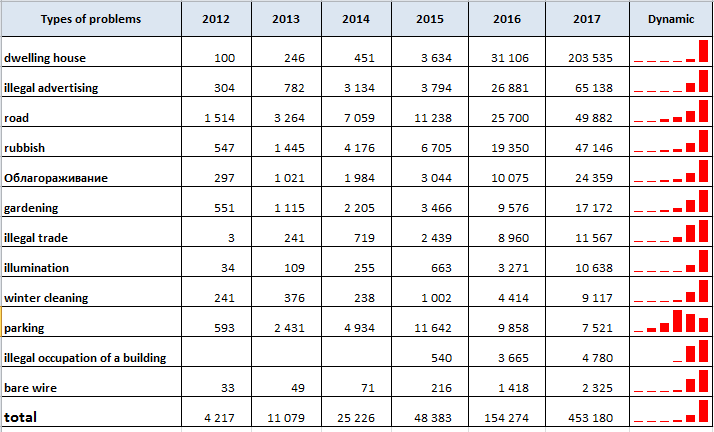

### Chapter 2  
Statistical modeling of spatial phenomena helps to generalize accumulated observations and build a model of their distribution in spaces and time.  
An important property of spatially distributed data is spatial continuity, which implies that closely spaced measurements will most likely have close values. The spatial continuity of data is most often described by correlation and covariance functions (statistical moments), which demonstrate a measure of this continuity. In geostatistics, correlation can be represented by statistical moments. One of the most used functions is a semivariogram - a second-order statistical two-point moment:

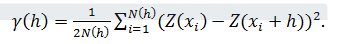
 
https://www.researchgate.net/publication/229673066_Geostatistics_Spatial_Predictions_and_Simulations
https://www.sciencedirect.com/science/article/abs/pii/S0377221715006463 

Example of requests with accidents in the water supply system for October-December 2017 (a red marker means a repeated accident in the house, a blue marker is an isolated case for the specified period):

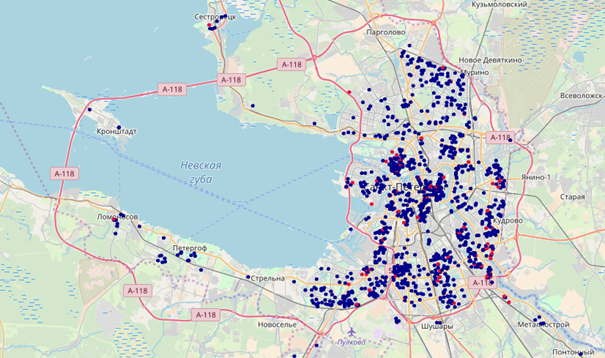

Here is experimental and theoretical variogram, describing distribution of accidents in the water supply system:  
##### you can see strong influence within a radius of 3 blocks (3 * 250 = 750 meters).

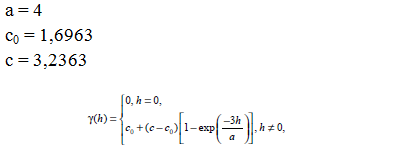

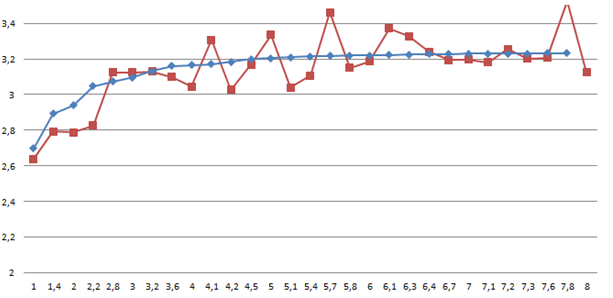

Kriging assessment of the total number of requests with accidents in the water supply system for 2016-2017 (increase in accident rate from blue to red according to the proposed scale):

##### the most risky region is the city center, where there is high dense of old buildings

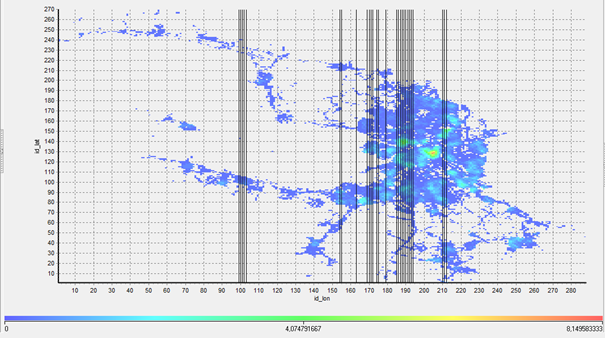

### Chapter 3


Early assessment of the occurrence of an emergency is the key to maintaining the city budget - therefore, the proposed model calculates the probability of an accident for sites measuring 250 meters by 250 meters with residential buildings for the next month.

I use the kriging estimate calculated in Chapter 2 as input factor that reinforce the predictive power of the model.  

Here is description of all input data:

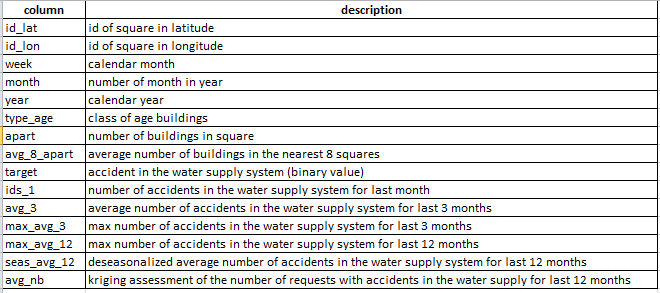

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

In [2]:
data=pd.read_csv('data_0_250_reg_water_disas.txt', encoding='cp1251', sep=';')
data['target']=np.where(data['ids']>0,1,0)

#### Share of problem squares (250m*250m) - about 10% :

In [4]:
data[['target','ids']].groupby(['target']).count()

,ids
target,
0,40776
1,4899


In [3]:
list_f=['ids','year','month','ids_12','avg_3_12','trend','index','avg_12','id_muni','id_region','id_elem','id_p','bud','ids_1_r','sigma_12','avg_3_r','t_day_3','p_day_3','t_ni_3','p_ni_3','wild_ni_3','wild_day_3','t_day_10','p_day_10','t_ni_10','p_ni_10','wild_ni_10','wild_day_10','level','eng_heatingcentral','eng_heatingauto','eng_heatingfire','eng_hotwater','eng_hotwatergas','eng_hotwaterwood','eng_electro','eng_gascentral','eng_gasnoncentral','eng_refusechute','roof_metalarea','outclean_all','param_failure','roof_m','clean_m','type_age','persons']
list_fa=['target','id_lat','id_lon','week','avg_3', 'avg_nb', 'max_avg_3', 'ids_1', 'apart', 'avg_8_apart', 'max_avg_12','seas_avg_12']

##### Dividing dataset on train (jan2017-feb2018) and test (mar2018).       
##### Part of columns ['year','month','type_age'] are categorial.    
##### The best model is GradientBoostingClassifier with parameters [n_estimators=500, learning_rate=0.1,max_depth=2].

In [19]:
df=data
cat_factor=pd.get_dummies(df[['year','month','type_age']].astype(str),drop_first=True)
x_fa=df[list_fa]
df0=pd.concat([x_fa,cat_factor],axis=1).fillna(0)
df1=df0[(df0['week']<20180301)&(df0['week']>=20170101)]
df2=df0[(df0['week']>=20180301)]
y_train=df1['target'].values
y_test=df2['target'].values
#X_train=df1.drop(['ids_','common_type','id_lat','id_lon','week'],axis=1).values
#X_test=df2.drop(['ids_','common_type','id_lat','id_lon','week'],axis=1).values
X_train=df1.drop(['target','id_lat','id_lon','week'],axis=1)
X_test=df2.drop(['target','id_lat','id_lon','week'],axis=1)
#tree = ensemble.RandomForestClassifier(n_estimators=500, random_state=101)
tree=ensemble.GradientBoostingClassifier(n_estimators=500, learning_rate=0.1,max_depth=2,random_state=101)
tree.fit(X_train, y_train)
#tree_train_pred = tree.predict(X_train)
df2['fcst_proba'] = tree.predict_proba(X_test)[:,1]

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### In my model I use threshold = 0.168 to define the most problem squares.                                                                                          
#### Also I compare my model with simple model (baseline), which defines the most problem squares like squares with max_avg_12 > 0.33.

In [25]:
df2['fcst']=np.where(df2['fcst_proba']>0.168,1,0)
df2['fcst_simple']=np.where(df2['max_avg_12']>0.33,1,0)

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Predictive quality of my model = 128 / (178+128) = 42%

In [23]:
print(df2[['target','fcst','id_lat']].groupby(['target','fcst']).count())

             id_lat
target fcst        
0      0       1625
       1        178
1      0        249
       1        128


#### Predictive quality of simple model = 85 / (221+85) = 28%

In [24]:
print(df2[['target','fcst_simple','id_lat']].groupby(['target','fcst_simple']).count())

                    id_lat
target fcst_simple        
0      0              1582
       1               221
1      0               292
       1                85


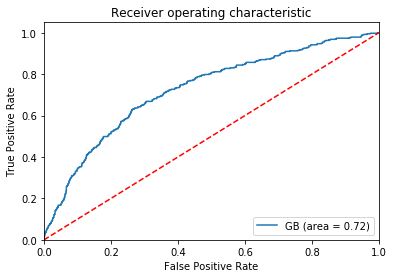

In [26]:
# Let's also estimate rocauc of my model
logit_roc_auc = roc_auc_score(y_test, df2['fcst_proba'])
fpr, tpr, thresholds = roc_curve(y_test, df2['fcst_proba'])
plt.figure()
plt.plot(fpr, tpr, label='GB (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Let's estimate potential improvement in money of using my model: if plumbers use my recommendations beforehand, department of water supply system can save below calculated money in their budget every month.

### If plumber checks  300 suggested squares every month beforehand and happened accident costs about 2000 dollars for fixing, then we can avoid about additional costs per month: 300*(0.42-0.28)*2000 dollars - 1000 dollars ( salary of plumber per month) - 1000 dollars (cost of calculating model) = 82 000 dollars.